# get-mean-variance-proteins
3.9.23

Want to repeat the mean-x-variance plots with protein level quant data. 
This will be a supplementary figure in the manuscript. Have protein quants for `PXD016079`, `PXD006109` and `PXD014525`, but not `PXD034525`.

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt

# plotting templates
sns.set(context="talk", style="ticks") 
sns.set_palette("tab10")

#### Configs

In [3]:
# main 
stem = "path/to/the/data"

n_replicates = [3,6,10]
pxds = ["PXD016079", "PXD014525", "PXD006109"]

#### Helper funcs

In [4]:
def get_mean_var_std(df, n_replicates):
    """ 
    For the intensity cols of a single MaxQuant dataframe, break down
    column-wise according to the number of replicates in the matrix, 
    then get means and variances for each peptide, for each replicate.
    Also get peptide standard deviations. 
        
    Assumes columns are in sorted order! as in, the replicate runs are
    next to one another. 
    
    Parameters
    ----------
    df: Matrix of intensity vals, for a single PRIDE experiment
    n_replicates: Number of replicates for each run within that PRIDE
                    experiment
    
    Returns
    -------
    all_means_flat: Flattened (1D) array of all peptide means
    all_vars_flat: Flattened (1D) array of all peptide variances
    all_stds_flat: Flattened (1D) array of all peptide standard deviations
    """
    
    cols = list(df.columns)
    r_split_cols = [cols[i:i+n_replicates] for i in range(0,len(cols), n_replicates)]

    all_means = []
    all_vars = []
    all_stds = []
    
    for i in df.index:
        peptide_means = []
        peptide_vars = []
        peptide_stds = []
    
        for j in range(0,len(r_split_cols)):
            rep_df = df[r_split_cols[j]]
            peptide_mean = np.nanmean(rep_df.iloc[i])
            peptide_var = np.nanvar(rep_df.iloc[i])
            peptide_std = np.nanstd(rep_df.iloc[i])
        
            peptide_means.append(peptide_mean)
            peptide_vars.append(peptide_var)
            peptide_stds.append(peptide_std)
            
        all_means.append(peptide_means)
        all_vars.append(peptide_vars)
        all_stds.append(peptide_stds)
        
    all_means_flat = np.array(all_means).flatten()
    all_vars_flat = np.array(all_vars).flatten()
    all_stds_flat = np.array(all_stds).flatten()
        
    return all_means_flat, all_vars_flat, all_stds_flat

#### The main loop 
For each protein quants dataset, collect means and variances across technical replicate runs

In [5]:
aggregated = pd.DataFrame(columns=["means", "variances", "stds", "PXD"])

for pxd, n_rep in zip(pxds, n_replicates):
    print("working on: ", pxd)
    # read in, convert 0s to np.nans
    df = pd.read_csv(stem + pxd + "_proteinGroups.csv")
    df[df==0] = np.nan
    
    means, variances, stds = get_mean_var_std(df, n_rep)
    
    tmp = pd.DataFrame(columns=["means", "variances", "stds", "PXD"])
    tmp["means"] = means
    tmp["variances"] = variances
    tmp["stds"] = stds
    tmp["PXD"] = pxd
    
    aggregated = pd.concat([aggregated, tmp], ignore_index=False)
    
aggregated = aggregated.reindex()

# set zeros to np.nan....my guess is that a zero variance
#     or zero std value corresponds to a peptide that only 
#     had a quant value for a single replicate
aggregated[aggregated==0] = np.nan

working on:  PXD016079


/net/gs/vol3/software/modules-sw-python/3.7.7/jupyter/5.7.9/Linux/CentOS7/x86_64/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/net/gs/vol3/software/modules-sw-python/3.7.7/jupyter/5.7.9/Linux/CentOS7/x86_64/ipykernel_launcher.py:39: RuntimeWarning: Degrees of freedom <= 0 for slice.
/net/noble/vol2/home/lincolnh/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


working on:  PXD014525
working on:  PXD006109


#### The main loop, for the logged quants

In [6]:
aggregated_log = pd.DataFrame(columns=["means", "variances", "stds", "PXD"])

for pxd, n_rep in zip(pxds, n_replicates):
    print("working on: ", pxd)
    # read in, convert 0s to np.nans
    df = pd.read_csv(stem + pxd + "_proteinGroups.csv")
    df[df==0] = np.nan
    
    # log the peptide quants
    df = np.log(df)
    
    means, variances, stds = get_mean_var_std(df, n_rep)
    
    tmp = pd.DataFrame(columns=["means", "variances", "stds", "PXD"])
    tmp["means"] = means
    tmp["variances"] = variances
    tmp["stds"] = stds
    tmp["PXD"] = pxd
    
    aggregated_log = pd.concat([aggregated_log, tmp], ignore_index=False)
    
aggregated_log = aggregated_log.reindex()

# set zeros to np.nan....my guess is that a zero variance
#     or zero std value corresponds to a peptide that only 
#     had a quant value for a single replicate
aggregated_log[aggregated_log==0] = np.nan

working on:  PXD016079


/net/gs/vol3/software/modules-sw-python/3.7.7/jupyter/5.7.9/Linux/CentOS7/x86_64/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/net/gs/vol3/software/modules-sw-python/3.7.7/jupyter/5.7.9/Linux/CentOS7/x86_64/ipykernel_launcher.py:39: RuntimeWarning: Degrees of freedom <= 0 for slice.


working on:  PXD014525
working on:  PXD006109


***

## Plot

#### Get mins and maxes for the non-logged plot

In [7]:
# get the mins and maxes of the means and vars
means_qmax = np.nanquantile(aggregated["means"], 0.999)
means_qmin = np.nanquantile(aggregated["means"], 0.001)

vars_qmax = np.nanquantile(aggregated["variances"], 0.999)
vars_qmin = np.nanquantile(aggregated["variances"], 0.001)

axes_max = np.max([means_qmax, vars_qmax])
axes_min = np.min([means_qmin, vars_qmin])

# this was hand tuned....probably not ideal
axes_min = 1
axes_max = axes_max + 1e24

#### Generate side-by-side plot

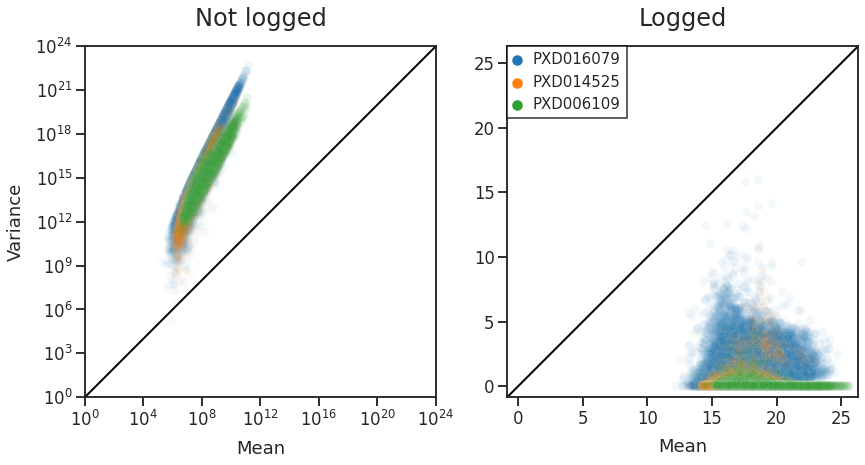

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6)) #sharey=False, sharex=False
fig.tight_layout()

sns.scatterplot(
    data=aggregated, x="means", y="variances", hue="PXD", 
    alpha=0.03, edgecolors="none", ax=axes[0])
axes[0].minorticks_off()
axes[0].set_xlabel("Mean", labelpad=10)
axes[0].set_ylabel("Variance", labelpad=10)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Not logged", size=24, pad=20)
axes[0].get_legend().remove()

axes[0].plot(
    [axes_min, axes_max], [axes_min, axes_max], 
    color="black", zorder=0, alpha=1, linewidth=2)
axes[0].set_aspect('equal', 'box')

# set axis limits for the non-logged plot
axes[0].set_xlim(axes_min, axes_max)
axes[0].set_ylim(axes_min, axes_max)

sns.scatterplot(
    data=aggregated_log, x="means", y="variances", hue="PXD", 
    alpha=0.05, edgecolors="none", ax=axes[1])
axes[1].minorticks_off()
axes[1].set_xlabel("Mean", labelpad=10)
axes[1].set_ylabel("")
axes[1].set_title("Logged", size=24, pad=20)
#axes[1].get_legend().remove()

# plot the y=x line. And establish the axis limits
lims1 = [
        np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
        np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
        ]

axes[1].plot(lims1, lims1, color="black", zorder=0, alpha=1, linewidth=2)
axes[1].set_aspect('equal', 'box')

# set axis limits for the logged plot
axes[1].set_xlim(lims1)
axes[1].set_ylim(lims1)

axes[1].legend(
        frameon=True, 
        fancybox=False, 
        loc="upper left", 
        edgecolor="black",
        handlelength=0.5,
        borderaxespad=0,
        fontsize="small",
)

# plt.savefig("path/to/the/data", dpi=250, bbox_inches="tight")